In [1]:
import json
import plotly.express as px
import pandas as pd
from datetime import datetime
import numpy as np
import json
import warnings
import geojson
import plotly.graph_objs as go
from prophet import Prophet
warnings.filterwarnings("ignore")

## Data Exploration

### Our World in Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

The dataframe contains columns which are not necassary. Therefore these will be dropped.

In [4]:
# Only consider relevant columns
df = df[['iso_code','date','location', 'continent','new_cases_per_million', 'total_cases','new_deaths_per_million','total_deaths']]

* iso_code for identifing a certain location and for using it in a map
* location represents the country
* new_cases_per_million gibt die täglich bestätigten neuen Fallzahlen an pro 1 Million Einwohner
* total_cases Aufsummierte Anzahl an bestätigten Fallzahlen
* new_deaths_per_million gibt die täglich bestätigten neuen Todesfälle an pro 1 Million Einwohner
* total_deaths Aufsummierte Anzahl an bestätigten Todesfällen

#### Nan Values

In [5]:
pd.DataFrame(df.isna().sum()).transpose()

,iso_code,date,location,continent,new_cases_per_million,total_cases,new_deaths_per_million,total_deaths
0,0,0,0,9540,3639,2863,20941,20399


Der Datensatz enthält keine fehlenden Werte in den Spalten iso_code, date und location weshalb keine Bereinigung stattfinden muss. Die fehlenden Werten in den numerischen Spalten resultieren daraus, dass keine Daten gemeldet wurden. Sie können daher einfach ignoriert werden.

#### Check unique values 

In [6]:
df.iso_code.nunique() , df.location.nunique()

(238, 238)

Jedem Land ist ein Iso-Code zugeordnet, mit dem dieses eindeutig identifiziert werden kann. Der Iso-Code wird benötigt um beispielsweise Chloropleth-Maps zu erstellen.

#### Check erster Corona-Fall

In [7]:
min(df[df['new_cases_per_million']>0].date)

'2020-01-23'

In [8]:
px.bar(df[df['new_cases_per_million']>0].groupby('date').sum().reset_index(),x="date",y="new_cases_per_million",template="plotly_white")

### DIVI Intensivregister

In [9]:
divi = pd.read_csv("https://diviexchange.blob.core.windows.net/%24web/zeitreihe-tagesdaten.csv")
divi.head()

,date,bundesland,gemeindeschluessel,anzahl_standorte,anzahl_meldebereiche,faelle_covid_aktuell,faelle_covid_aktuell_invasiv_beatmet,betten_frei,betten_belegt,betten_belegt_nur_erwachsen,betten_frei_nur_erwachsen
0,2020-04-24,1,1001,2,2,1,1,40,38,38,40
1,2020-04-24,1,1002,3,4,4,3,93,108,108,93
2,2020-04-24,1,1003,2,2,4,4,109,108,108,109
3,2020-04-24,1,1004,1,1,1,1,17,21,21,17
4,2020-04-24,1,1051,1,1,3,1,47,25,25,47


In [10]:
divi.columns

Index(['date', 'bundesland', 'gemeindeschluessel', 'anzahl_standorte',
       'anzahl_meldebereiche', 'faelle_covid_aktuell',
       'faelle_covid_aktuell_invasiv_beatmet', 'betten_frei', 'betten_belegt',
       'betten_belegt_nur_erwachsen', 'betten_frei_nur_erwachsen'],
      dtype='object')

In [11]:
# Es werden nur relevante Spalten betrachtet
divi = divi[['date', 'bundesland', 'gemeindeschluessel',  'faelle_covid_aktuell',
       'faelle_covid_aktuell_invasiv_beatmet', 'betten_frei', 'betten_belegt']]

Der Datensatz enthält die täglichen Meldungen an Corona Infizierten, invasis beatmeten Infizierten sowie die Bettenbelegung je Landkreis.
In der CSV-Datei sind die Kreise und Bundesländer nach dem Amtlichen Gemeindeschlüssel kodiert.
- 01 Schleswig-Holstein
- 02 Hamburg
- 03 Niedersachsen
- 04 Bremen
- 05 Nordrhein-Westfalen
- 06 Hessen
- 07 Rheinland-Pfalz
- 08 Baden-Württemberg
- 09 Bayern
- 10 Saarland
- 11 Berlin
- 12 Brandenburg
- 13 Mecklenburg-Vorpommern
- 14 Sachsen
- 15 Sachsen-Anhalt
- 16 Thüringen

Um die jeweiligen Landkreise auch namentlich identifizieren zu können, müssen diese im nächsten Schritt über Geodaten angereichert werden. 

In [12]:
print('Anzahl Bundesländer im Datensatz:', divi.bundesland.nunique())

Anzahl Bundesländer im Datensatz: 16


In [13]:
divi.describe()

,bundesland,gemeindeschluessel,faelle_covid_aktuell,faelle_covid_aktuell_invasiv_beatmet,betten_frei,betten_belegt
count,257225.000000,257225.000000,257225.000000,257225.000000,257225.000000,257225.000000
mean,7.953531,8278.984512,5.719401,3.254050,15.406368,54.100367
std,3.801141,3760.264167,13.777154,8.893207,22.474310,83.953461
min,1.000000,1001.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5754.000000,0.000000,0.000000,4.000000,13.000000
50%,8.000000,8226.000000,2.000000,1.000000,9.000000,29.000000
75%,9.000000,9677.000000,6.000000,3.000000,19.000000,61.000000
max,16.000000,16077.000000,458.000000,307.000000,485.000000,1157.000000


### RKI

In [14]:
rki = pd.read_csv("https://raw.githubusercontent.com/robert-koch-institut/COVID-19-Impfungen_in_Deutschland/master/Aktuell_Deutschland_Landkreise_COVID-19-Impfungen.csv")
rki.head()

,Impfdatum,LandkreisId_Impfort,Altersgruppe,Impfschutz,Anzahl
0,2020-12-27,1003,18-59,1,9
1,2020-12-27,1003,60+,1,19
2,2020-12-27,1053,18-59,1,13
3,2020-12-27,1053,60+,1,200
4,2020-12-27,1055,18-59,1,20


- LandkreisId_Impfort: Identifikationsnummer des Landkreises basierend auf dem Amtlichen Gemeindeschlüssel (AGS). Impfungen des Bundesressorts werden separat ausgewiesen, da die Impfstellen des Bundes ohne exakte Angabe des Impfortes melden.
- Altersgruppe: Altersgruppen der in der Impfgruppe enthaltenen Fälle nach Schema der KBV
- Impfschutz: 1: Unvollständiger Impfschutz, 2: Vollständiger Impfschutz, 3: Aufgefrischter Impfschutz

In [15]:
px.histogram(rki.groupby(['Impfdatum','Impfschutz']).sum().reset_index(),'Impfdatum', 'Anzahl',color='Impfschutz')

In [16]:
px.histogram(rki.groupby(['Impfdatum','Altersgruppe','Impfschutz']).sum().reset_index(),'Impfdatum', 'Anzahl',color='Altersgruppe')

## Data Preparation

### Our World in Data

In [17]:
# Sort dataframe by date
df = df.sort_values(by="date")

# Convert date to pd datetime object
df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')

# Extracting day month year from date
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['month_year'] = df['date'].dt.to_period('M')

In [18]:
# Since there is no data available before, we will shorten the dataframe 
df = df[df.date > "2020-01-22"]

# Aggregate the data on a monthly basis for each country 
df = df.groupby(['iso_code','month_year','month','year','location','continent']).sum().reset_index()

# Sort dataframe by month
df = df.sort_values(by="month_year")

# To extract only data regarding Germany
germany = df[df.location == 'Germany']

### DIVI

Anreicherung der DIVI Daten um die Infos der Landkreise sowie hinzufügen des Bundeslandes als Name.
Die Daten werden aus einer Geojson Datei gewonnen.

In [19]:
path_to_file = 'landkreise.geojson'
with open(path_to_file) as f:
    land_geojson= geojson.load(f)

In [20]:
land_geojson['features'][0]['properties']

{'ADE': 4,
 'GF': 4,
 'BSG': 1,
 'RS': '01001',
 'AGS': '01001',
 'SDV_RS': '010010000000',
 'GEN': 'Flensburg',
 'BEZ': 'Kreisfreie Stadt',
 'IBZ': 40,
 'BEM': '--',
 'NBD': 'ja',
 'SN_L': '01',
 'SN_R': '0',
 'SN_K': '01',
 'SN_V1': '00',
 'SN_V2': '00',
 'SN_G': '000',
 'FK_S3': 'R',
 'NUTS': 'DEF01',
 'RS_0': '010010000000',
 'AGS_0': '01001000',
 'WSK': '2008/01/01',
 'DEBKG_ID': 'DEBKGDL20000002R'}

AGS steht für den Gemeindeschlüssel im DIVI Datensatz. Desweiteren enthält die Geojson noch den Name des Landkreises.

In [21]:
# Alle Landkreise werden in einer Liste abgespeichert
codes = divi['gemeindeschluessel'].astype('int').drop_duplicates()
codes = codes.tolist()

dict_codes = {}

# Da die Daten in der DIVI Datei teilweise 4- bzw. 5 stellig vorliegen, sollen diese 5stellig standardisiert werden. Bsp. 1001 wird zu 01001
# Die alten Codes aus der DIVI Datei werden mit den standardisierten in einem Dictionary abgespeichert 

for x in range(0,len(codes)):
   
    code = codes[x]

    if code < 10000:
        dict_codes[code] = "0"+str(code)
    else:
        dict_codes[code] = str(code)
dict_codes

{1001: '01001',
 1002: '01002',
 1003: '01003',
 1004: '01004',
 1051: '01051',
 1053: '01053',
 1054: '01054',
 1055: '01055',
 1056: '01056',
 1057: '01057',
 1058: '01058',
 1059: '01059',
 1060: '01060',
 1061: '01061',
 1062: '01062',
 2000: '02000',
 3101: '03101',
 3102: '03102',
 3103: '03103',
 3151: '03151',
 3153: '03153',
 3154: '03154',
 3155: '03155',
 3157: '03157',
 3158: '03158',
 3159: '03159',
 3241: '03241',
 3251: '03251',
 3252: '03252',
 3254: '03254',
 3255: '03255',
 3256: '03256',
 3257: '03257',
 3351: '03351',
 3352: '03352',
 3353: '03353',
 3354: '03354',
 3355: '03355',
 3356: '03356',
 3357: '03357',
 3358: '03358',
 3359: '03359',
 3360: '03360',
 3361: '03361',
 3401: '03401',
 3402: '03402',
 3403: '03403',
 3404: '03404',
 3405: '03405',
 3451: '03451',
 3452: '03452',
 3453: '03453',
 3454: '03454',
 3455: '03455',
 3456: '03456',
 3457: '03457',
 3458: '03458',
 3459: '03459',
 3460: '03460',
 3461: '03461',
 3462: '03462',
 4011: '04011',
 4012: '

In [22]:
# Der neue Standardisierte Gemeindeschlüssel wird aus dem Dictionary über den bisherigen identifiziert und als neue Spalte dem Datensatz angehängt. 
divi["id"] = divi["gemeindeschluessel"].apply(lambda x: dict_codes[x])

# Die Bundesländer werden ebenfalls in einem Dictionary mit dem jeweiligen Bundesländercode versehen
bundesland = ["Schleswig-Holstein","Hamburg","Niedersachsen","Bremen","Nordrhein-Westfalen","Hessen","Rheinland-Pfalz","Baden-Württemberg","Bayern","Saarland","Berlin","Brandenburg","Mecklenburg-Vorpommern","Sachsen","Sachsen-Anhalt","Thüringen"]
code = range(1,17)
bund_code = dict(zip(code, bundesland))

# Der Name des Bundeslandes wird über den Code im Dictionary identifiziert
divi["bundesland_name"] = divi["bundesland"].apply(lambda x: bund_code[x])

# Die Landkreise werden mit dem Gemeindeschlüssel in einem Dictionary gespeichert
dict_landkreise = {}
for feature in land_geojson['features']:
    dict_landkreise[feature["properties"]["AGS"]] = feature["properties"]["GEN"]

# Der Landkreisname wird über die jeweilige standardisierte ID identifiziert und dem Datensatz hinzugefügt
divi["name"] = divi["id"].apply(lambda x: dict_landkreise[x])

In [23]:
# Datensatz wird auf die benötigten Spalten reduziert
divi = divi[['date','id', 'bundesland_name', 'name','faelle_covid_aktuell',
       'faelle_covid_aktuell_invasiv_beatmet', 'betten_frei', 'betten_belegt']]
divi.head()

,date,id,bundesland_name,name,faelle_covid_aktuell,faelle_covid_aktuell_invasiv_beatmet,betten_frei,betten_belegt
0,2020-04-24,01001,Schleswig-Holstein,Flensburg,1,1,40,38
1,2020-04-24,01002,Schleswig-Holstein,Kiel,4,3,93,108
2,2020-04-24,01003,Schleswig-Holstein,Lübeck,4,4,109,108
3,2020-04-24,01004,Schleswig-Holstein,Neumünster,1,1,17,21
4,2020-04-24,01051,Schleswig-Holstein,Dithmarschen,3,1,47,25


### RKI

In [24]:
# Dataset wird gefiltert
rki = rki[rki.LandkreisId_Impfort != "u"]

# Landkreis Ids werden als integer markiert
rki.LandkreisId_Impfort = rki.LandkreisId_Impfort.astype('int')

#### Anreicherung der Daten mit 5-stelligen Landkreis Ids

Die Landkreis Ids ohne Duplikate in einer List gespeichert.

In [25]:
lk = rki.LandkreisId_Impfort.drop_duplicates().tolist()
lk[:5]

[1003, 1053, 1055, 1056, 1057]

Da die Landkreise nicht alle 5-stellig vorliegen, wird ein dictionary mit dem 4-stelligen und dem 5-stelligen Wert gebildet. Den 4-stelligen Zahlen wird an der ersten Stelle eine 0 hinzugefügt.

So entsteht bspw. das Key-Value Paar:
1003:01003

Ist die Zahl bereits fünfstellig, so wird der Wert der Liste gespiegelt.
12002:12002

In [26]:
dict_ids = {}
for x in lk:
    if x < 10000:
        dict_ids[x] = "0"+str(x)
    else:
        dict_ids[x] = str(x)
dict_ids[1003], dict_ids[10042]

('01003', '10042')

Die neue Id wird über die Column LandkreisId_Impfort, deren Wert als Key im Dictionary vorliegt, als neue Spalte im Datensatz angelegt.

In [27]:
rki['Id'] = rki["LandkreisId_Impfort"].apply(lambda x: dict_ids[x])
# Die alte Id wird aus dem Datensatz gelöscht
rki = rki.drop('LandkreisId_Impfort',axis=1)
# Da keine Id mit 17000 in der Realität existiert, wird diese aus dem Datensatz entfernt
rki = rki[rki.Id != '17000']

Da nun die vollständigen Ids der Landkreise vorliegen, können die Daten nun mit Informationen aus der geojson angereichert werden.

In [28]:
rki["Name"] = rki["Id"].apply(lambda x: dict_landkreise[x])
rki.head()

,Impfdatum,Altersgruppe,Impfschutz,Anzahl,Id,Name
0,2020-12-27,18-59,1,9,01003,Lübeck
1,2020-12-27,60+,1,19,01003,Lübeck
2,2020-12-27,18-59,1,13,01053,Herzogtum Lauenburg
3,2020-12-27,60+,1,200,01053,Herzogtum Lauenburg
4,2020-12-27,18-59,1,20,01055,Ostholstein


In [29]:
rki.head()

,Impfdatum,Altersgruppe,Impfschutz,Anzahl,Id,Name
0,2020-12-27,18-59,1,9,01003,Lübeck
1,2020-12-27,60+,1,19,01003,Lübeck
2,2020-12-27,18-59,1,13,01053,Herzogtum Lauenburg
3,2020-12-27,60+,1,200,01053,Herzogtum Lauenburg
4,2020-12-27,18-59,1,20,01055,Ostholstein


In [30]:
divi

,date,id,bundesland_name,name,faelle_covid_aktuell,faelle_covid_aktuell_invasiv_beatmet,betten_frei,betten_belegt
0,2020-04-24,01001,Schleswig-Holstein,Flensburg,1,1,40,38
1,2020-04-24,01002,Schleswig-Holstein,Kiel,4,3,93,108
2,2020-04-24,01003,Schleswig-Holstein,Lübeck,4,4,109,108
3,2020-04-24,01004,Schleswig-Holstein,Neumünster,1,1,17,21
4,2020-04-24,01051,Schleswig-Holstein,Dithmarschen,3,1,47,25
...,...,...,...,...,...,...,...,...
257220,2022-02-02,16073,Thüringen,Saalfeld-Rudolstadt,1,1,7,15
257221,2022-02-02,16074,Thüringen,Saale-Holzland-Kreis,0,0,2,4
257222,2022-02-02,16075,Thüringen,Saale-Orla-Kreis,1,0,0,3
257223,2022-02-02,16076,Thüringen,Greiz,0,0,3,7


Die RKI Daten werden mit den DIVI Daten gemerged und darum ergänzt.

In [31]:
rki = pd.merge(rki,divi[['id','bundesland_name']].drop_duplicates(), left_on=["Id"], right_on=["id"], how="left")
rki = rki.drop('id',axis=1)
rki.head()

,Impfdatum,Altersgruppe,Impfschutz,Anzahl,Id,Name,bundesland_name
0,2020-12-27,18-59,1,9,01003,Lübeck,Schleswig-Holstein
1,2020-12-27,60+,1,19,01003,Lübeck,Schleswig-Holstein
2,2020-12-27,18-59,1,13,01053,Herzogtum Lauenburg,Schleswig-Holstein
3,2020-12-27,60+,1,200,01053,Herzogtum Lauenburg,Schleswig-Holstein
4,2020-12-27,18-59,1,20,01055,Ostholstein,Schleswig-Holstein


In [32]:
# Der Impfschutz ist als Integer hinterlegt und wird nun mit einem Wert versehen, der selbstsprechend ist
rki.loc[rki.Impfschutz == 1, "Impfschutz"] = "Erstimpfung"
rki.loc[rki.Impfschutz == 2, "Impfschutz"] = "Zweitimpfung"
rki.loc[rki.Impfschutz == 3, "Impfschutz"] = "Boosterimpfung"

#Die Spalten werden umbenannt
rki.columns = ['Datum','Altersgruppe','Impfschutz','Anzahl','Id','Landkreis','Bundesland']
rki.head()

,Datum,Altersgruppe,Impfschutz,Anzahl,Id,Landkreis,Bundesland
0,2020-12-27,18-59,Erstimpfung,9,01003,Lübeck,Schleswig-Holstein
1,2020-12-27,60+,Erstimpfung,19,01003,Lübeck,Schleswig-Holstein
2,2020-12-27,18-59,Erstimpfung,13,01053,Herzogtum Lauenburg,Schleswig-Holstein
3,2020-12-27,60+,Erstimpfung,200,01053,Herzogtum Lauenburg,Schleswig-Holstein
4,2020-12-27,18-59,Erstimpfung,20,01055,Ostholstein,Schleswig-Holstein


### Prophet 

Für den Forecast muss das DIVI Dataset nochmal angepasst werden. Prophet benötigt für den Forecast zwei Spalten: das Datum und den y-Wert, der vorhergesagt werden soll. Diese beiden Spalten müssen im Datensatz als ds und y hinterlegt sein. 

In [33]:
cases_prophet= divi[['date','faelle_covid_aktuell']].groupby('date').sum().reset_index()
cases_prophet.columns = ['ds','y']

In [34]:
cases_prophet.head()

,ds,y
0,2020-04-24,2650
1,2020-04-25,2543
2,2020-04-26,2529
3,2020-04-27,2471
4,2020-04-28,2394


## Predictive Modeling

In [54]:
m = Prophet(interval_width=0.95,changepoint_prior_scale=0.01,seasonality_mode='multiplicative',daily_seasonality=False,weekly_seasonality=True,yearly_seasonality=True,changepoint_range=0.6)
m.fit(cases_prophet)
# Die nächsten 90 Tage werden vorhergesagt
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)
# Der ursprüngliche y-Wert wird dem Datensatz hinzugefügt.
forecast['y'] = cases_prophet['y']

# Der Forecast wird in einem separaten Datensatz abgespeichert. Es werden nur Zeilen betrachtet, die in der Zukunft liegen und daher keinen y-Wert haben.
pred = forecast[forecast.y.isna()]
pred[['ds','y','yhat']].describe()

Initial log joint probability = -32.6362
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1460.57    0.00831008       617.961           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1469.18   0.000668807       645.467   8.637e-07       0.001      192  LS failed, Hessian reset 
     155       1474.67   0.000481147       558.508   8.491e-07       0.001      276  LS failed, Hessian reset 
     199       1476.01    0.00180949       469.766      0.6283      0.6283      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       1476.56   0.000253536       402.886   6.284e-07       0.001      443  LS failed, Hessian reset 
     299       1476.63   8.16671e-07       328.742       0.339           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

,y,yhat
count,0.0,180.000000
mean,NaN,1326.415986
std,NaN,811.092551
min,NaN,116.648235
25%,NaN,391.887879
50%,NaN,1541.867876
75%,NaN,2019.515844
max,NaN,2609.644567


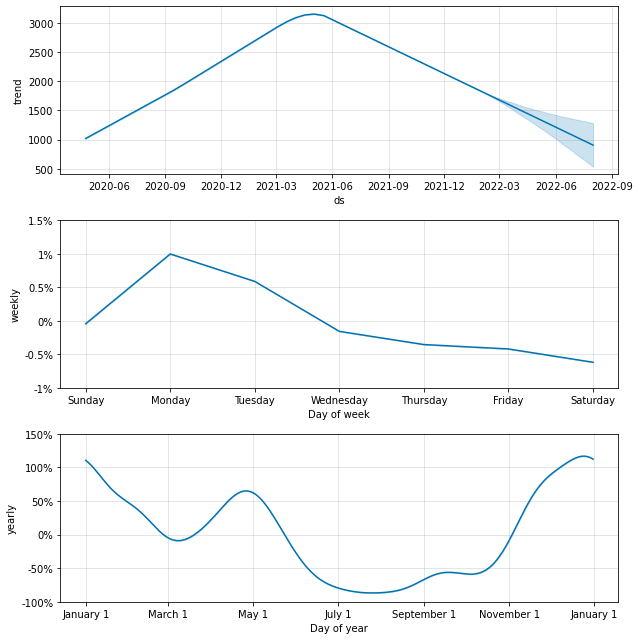

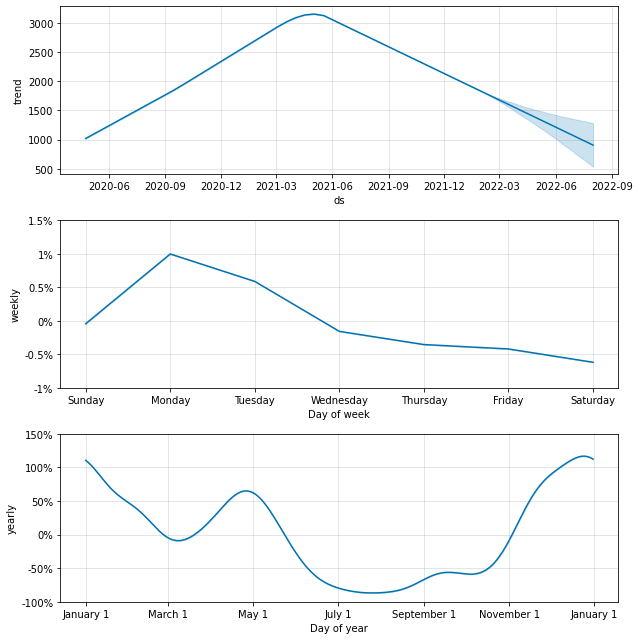

In [55]:
m.plot_components(forecast)

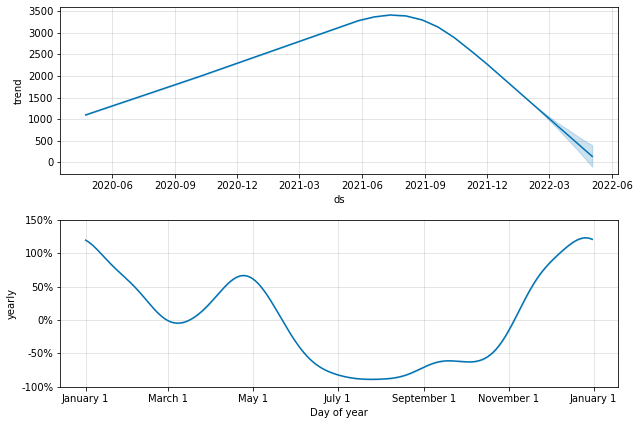

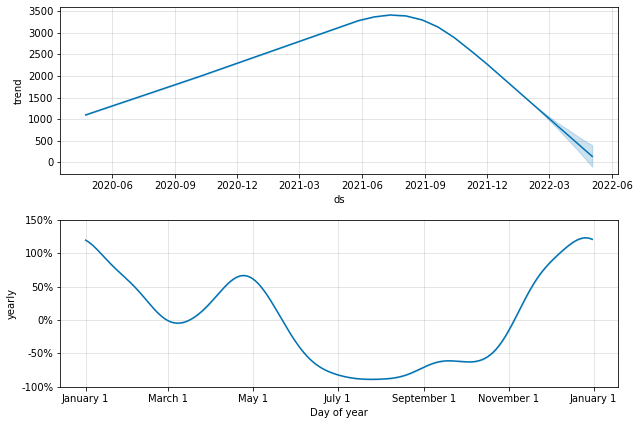

In [41]:
m.plot_components(forecast)

Sollte der Forecast negative Fallzahlen vorhersagen, dann werden diese mit einer 0 versehen.
Die Spalte 'yhat' sind die vorhergesagten Fallzahlen. yhat_lower und yhat_upper stellen das Konfidenzintervall dar. 

In [36]:
pred.loc[pred['yhat'] < 0, 'yhat'] = 0
pred.loc[pred['yhat_lower'] < 0, 'yhat_lower'] = 0
pred.loc[pred['yhat_upper'] < 0, 'yhat_upper'] = 0